#Тестовое Epoch8.co

# 1. inner / left
Что вернут запросы?

## Решение

```sql
SELECT * FROM A JOIN B ON A.id = B.id;
```

\begin{array}{ccc}
\text{id}&\text{id}&\\
1&1
\end{array}

```sql
SELECT * FROM A LEFT JOIN B ON A.id = B.id;
```

\begin{array}{ccc}
\text{id}&\text{id}&\\
1&1 \\
2&NULL
\end{array}

# 2. Лучший ученик
Напишите запрос, который для каждого предмета возвращает идентификатор лучшего ученика.

## Решение

Возможны два варианта:

1) Значение максимальной оценки `grade` уникально в пределах одного предмета `subject_id`:

```sql
SELECT subject_id, student_id 
FROM grades
GROUP BY subject_id
HAVING MAX(grade);
```

2) Значение оценки `grade` может повторяться в пределах группы `subject_id` для разных студентов `student_id`:

```sql 
SELECT g.subject_id, g.student_id
FROM grades AS g
INNER JOIN (
SELECT subject_id, MAX(grade) as max_grade
FROM grades
GROUP BY subject_id) AS t ON t.subject_id=g.subject_id AND t.max_grade=g.grade
ORDER BY g.subject_id
```

# 3. Онлайн-кассы

Характеристики данных:

1. Реляционная база данных.  
2. 4 таблицы
3. `PRIMERY_KEY`: product_id, id, payment_id
4. `FOREIGN KEY`: product_id, category_id, subscription_id, user_id
5. `app_category` связана с `app`
6. `app` связана с `subscription`
7. `subscription` и `payments` связаны друг с другом 
8. В данных имеются цельночисленные значения, числа с плавающей точкой, строки, тексты, даты, время, логическое булево.


1. Выведите количество активных подписок для каждого приложения с ID и наименованием приложения и ID и описанием категории.
2. Выведите количество пользователей, количество и сумму платежей по тем подпискам, которые были отменены в разрезе тарифов.
3. Выведите top-10 приложений по убыванию оборота по приложению.
4. Выведите top-3 приложений в каждой категории по убыванию оборота по приложению.

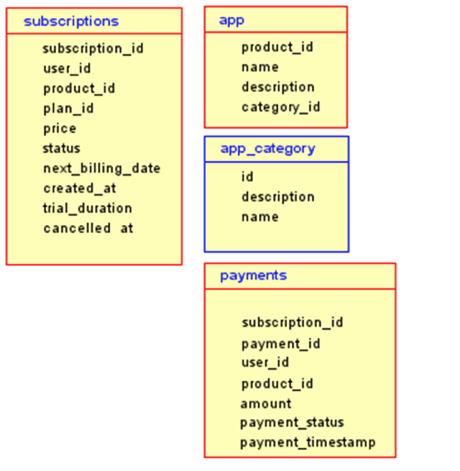

## Решение

1. Выведите количество активных подписок для каждого приложения с ID и наименованием приложения и ID и описанием категории.

```sql
SELECT a.product_id, a.name, ac.id, ac.description, SUM(CASE WHEN canceled_at IS NULL THEN 0 ELSE 1 END) AS cnt_true
FROM app AS a
JOIN app_category as ac ON ac.id=a.category_id
JOIN subscription AS s ON a.product_id=s.product_id
GROUP BY a.product_id
```

2. Выведите количество пользователей, количество и сумму платежей по тем подпискам, которые были отменены в разрезе тарифов.

``` sql
WITH t1 AS (
  SELECT subscription_id, user_id, SUM(amount) AS sum_amount
          FROM payments
          GROUP BY subscription_id, user_id
),

t2 AS (
  SELECT a.product_id, a.name,s.price, SUM(CASE WHEN canceled_at IS NULL THEN 1 ELSE 0 END) AS cnt, s.user_id, s.subscription_id
FROM app AS a
JOIN subscription AS s ON a.product_id=s.product_id
GROUP BY a.product_id
HAVING cnt > 0 
)

SELECT COUNT(t2.user_id), t1.sum_amount, t1.sum_amount * t2.price AS revenue, t2.subscription_id
FROM t2
JOIN t1 ON t1.user_id=t2.user_id
GROUP BY t2.subscription_id
```

3. Выведите top-10 приложений по убыванию оборота по приложению.

``` sql
WITH t1 AS (
  SELECT subscription_id, user_id, SUM(amount) AS sum_amount
          FROM payments
          GROUP BY subscription_id, user_id
),

t2 AS (
  SELECT a.product_id, a.name,s.price, SUM(CASE WHEN canceled_at IS NULL THEN 1 ELSE 0 END) AS cnt, s.user_id, s.subscription_id
FROM app AS a
JOIN subscription AS s ON a.product_id=s.product_id
GROUP BY a.product_id
HAVING cnt > 0 
)

SELECT t2.product_id, t2.name, t1.sum_amount * t2.price AS revenue
FROM t2
JOIN t1 ON t1.user_id=t2.user_id
GROUP BY t2.product_id
ORDER BY revenue DESC
```

4. Выведите top-3 приложений в каждой категории по убыванию оборота по приложению.

``` sql
WITH t1 AS (
  SELECT subscription_id, user_id, SUM(amount) AS sum_amount
  FROM payments
  GROUP BY subscription_id, user_id
),

t2 AS (
  SELECT a.product_id, a.name,s.price, s.user_id, s.subscription_id, a.category_id
  FROM app AS a
  JOIN app_category as ac ON ac.id=a.category_id 
  JOIN subscription AS s ON a.product_id=s.product_id
  GROUP BY a.product_id
),


t3 AS (
  SELECT t2.category_id, t2.product_id, t2.name, t1.sum_amount * t2.price AS revenue
  FROM t2
  JOIN t1 ON t1.user_id=t2.user_id
  GROUP BY t2.product_id)

t4 AS (
  SELECT category_id, product_id, name, revenue, 
                                ROW_NUMBER() over (PARTITION BY product_id
                                                  ORDER BY revenue DESC) AS rnk
  FROM t3
  )

SELECT category_id, product_id, name
FROM t4
WHERE rnk <=3
ORDER BY category_id, product_id

```